# 라이브러리

In [4]:
import numpy as np
import torch
from __future__ import print_function
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
import torch.nn.functional as F
import time

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if cuda.is_available() else 'cpu'
path = "/content/drive/MyDrive/21_winter/CIFAR-100/cifar-100-python"
batch_size = 512

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 불러오기

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta_data = unpickle(path + "/meta")
train_data = unpickle(path + "/train")
test_data = unpickle(path + "/test")

train_data_data = train_data[b'data']
train_data_data.resize(50000,3,32,32)
train_data_data = np.concatenate((train_data_data,
                                  train_data_data[:,:,:,::-1]))
                                  
train_data_label = train_data[b'fine_labels']
train_data_label += train_data_label

test_data_data = test_data[b'data']
test_data_label = test_data[b'fine_labels']

"""
train_data_label = list(zip(train_data[b'coarse_labels'],
                       [i % 5 for i in train_data[b'fine_labels']]))
test_data_label = list(zip(test_data[b'coarse_labels'],
                        [i % 5 for i in test_data[b'fine_labels']]))
"""

"\ntrain_data_label = list(zip(train_data[b'coarse_labels'],\n                       [i % 5 for i in train_data[b'fine_labels']]))\ntest_data_label = list(zip(test_data[b'coarse_labels'],\n                        [i % 5 for i in test_data[b'fine_labels']]))\n"

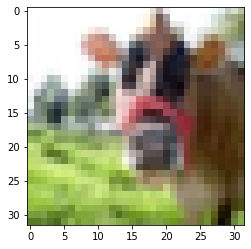

In [8]:

import matplotlib.pyplot as plt
plt.imshow(np.transpose(train_data_data[:,:,:,::-1][50000], (1, 2, 0)))


# 데이터 준비

In [9]:
class GH_Dataset_train(data.Dataset): 
    def __init__(self,X,Y):
        self.x_data = torch.from_numpy(X).type(dtype=torch.float32).resize_((len(X),3,32,32))
        self.y_data = torch.tensor(Y).resize_(len(X),1)

    def __len__(self): 
        return len(self.x_data)
    
    def __getitem__(self, idx): 
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

class GH_Dataset_test(data.Dataset): 
    def __init__(self,X,Y):
        self.x_data = torch.from_numpy(X).type(dtype=torch.float32).resize_((10000,3,32,32))
        self.y_data = torch.tensor(Y).resize_(10000,1)

    def __len__(self): 
        return len(self.x_data)
    
    def __getitem__(self, idx): 
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

train_dataset = GH_Dataset_train(train_data_data,train_data_label)
train_loader = data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

test_dataset = GH_Dataset_test(test_data_data,test_data_label)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

# 모델

In [ ]:
class GH(nn.Module):
    def __init__(self):
        super(GH,self).__init__()
        self.l1 = nn.Conv2d(3 ,64,3, padding = 1)

        self.l2 = nn.Conv2d(64,64, 3, padding = 1)
        self.l3 = nn.Conv2d(64,128,3, padding = 1)
        
        self.l4 = nn.Conv2d(128,128,3, padding = 1)
        self.l5 = nn.Conv2d(128,256,3, padding = 1)
        
        self.l6 = nn.Conv2d(256,256,3, padding = 1)
        self.l7 = nn.Conv2d(256,512,3, padding = 1)

        self.l8 = nn.Conv2d(512,512,3, padding = 1)
        self.l9 = nn.Conv2d(512,1024,3, padding = 1)

        self.l10 = nn.Conv2d(1024,1024,3, padding = 1)
        self.l11 = nn.Conv2d(1024,1024,3, padding = 1)


        self.ll1 = nn.Linear(4096,2048)   
        self.ll2 = nn.Linear(2048,512)
        self.ll3 = nn.Linear(512,100)
    
    def GH_Resnet(self,x,residual,k,GH_CONV,GH_CONV2,GH_POOL = True):
      for i in range(k):
        x = F.relu(GH_CONV(x))
        x = GH_CONV(x)
        x += residual
        residual = x
      
      x = F.relu(GH_CONV2(x))
      if GH_POOL:
        x = F.max_pool2d(x,2)
      residual = x 
      return x,residual

    def forward(self, x):      #(n,3,32,32)
        x = F.relu(self.l1(x)) #(n,64,32,32)
        residual = x           #residual : (n,64,32,32)

        x,residual = self.GH_Resnet(x,residual,3,self.l2,self.l3)                   # (n,128,16,16)
        x,residual = self.GH_Resnet(x,residual,1,self.l4,self.l5)                   # (n,256,8,8)
        x,residual = self.GH_Resnet(x,residual,3,self.l6,self.l7)                   # (n,512,4,4)
        x,residual = self.GH_Resnet(x,residual,1,self.l8,self.l9)                   # (n,512,2,2)
        x,residual = self.GH_Resnet(x,residual,3,self.l10,self.l11,GH_POOL = False) # (n,1024,2,2)
        
        x = x.view(-1,4096)     #(n,4096)
        x = F.relu(self.ll1(x)) #(n,2048)
        x = F.relu(self.ll2(x)) #(n,512 )
        x = F.relu(self.ll3(x)) #(n,100 )
        return x                #(n,100 )

In [ ]:
model = GH()
model.to(device)
model.load_state_dict(torch.load(path + "/GH_2(3694).pt"))



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, torch.squeeze(target))
        loss.backward()
        optimizer.step()
        if batch_idx % 100000 == 0:
            print('==================\nTrain Epoch : {} | Loss : {:.6f}'.format(epoch, loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, torch.squeeze(target)).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    test_loss /= len(test_loader.dataset)
    torch.save(model.state_dict(), path + "/GH_2" + str(correct)[6:] + '.pt')
    print(f'Test set: Average loss : {test_loss:.4f}, Accuracy : {correct}/{len(test_loader.dataset)}'
          f'({100. * correct / len(test_loader.dataset):.0f}%)')

# 모델 학습

In [ ]:
if __name__ == '__main__':
    since = time.time()
    for epoch in range(1,11):
        epoch_start = time.time()
        train(epoch)
        test()
        
        m, s = divmod(time.time() - epoch_start, 60)
        print(f'Training time: {m:.0f}m {s:.0f}s')
        
    m, s = divmod(time.time() - since, 60)
    print(f'Total time : {m:.0f}m {s: .0f}s \nModel was trained on {device}!')

Train Epoch : 1 | Loss : 3.515357
Test set: Average loss : 0.0072, Accuracy : 3954/10000(40%)
Training time: 6m 26s
Train Epoch : 2 | Loss : 0.414400
Test set: Average loss : 0.0080, Accuracy : 3996/10000(40%)
Training time: 6m 26s
Train Epoch : 3 | Loss : 0.355196
Test set: Average loss : 0.0085, Accuracy : 3983/10000(40%)
Training time: 6m 26s
Train Epoch : 4 | Loss : 0.397640
Test set: Average loss : 0.0086, Accuracy : 3976/10000(40%)
Training time: 6m 26s
Train Epoch : 5 | Loss : 0.369828
Test set: Average loss : 0.0086, Accuracy : 3998/10000(40%)
Training time: 6m 25s
Train Epoch : 6 | Loss : 0.387451
Test set: Average loss : 0.0089, Accuracy : 3983/10000(40%)
Training time: 6m 25s
Train Epoch : 7 | Loss : 0.360282
Test set: Average loss : 0.0087, Accuracy : 3992/10000(40%)
Training time: 6m 25s
Train Epoch : 8 | Loss : 0.378444
Test set: Average loss : 0.0090, Accuracy : 3991/10000(40%)
Training time: 6m 25s
Train Epoch : 9 | Loss : 0.288197
Test set: Average loss : 0.0089, Accur